In [ ]:
import pandas as pd
import numpy as np
import umap.plot
from scipy.spatial import distance
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler,Normalizer

In [82]:
# df = pd.read_csv('./out/07_07_uncertain_upsfix_supcon.csv')
df_train = pd.read_csv('./out/builtpreds/shufflerun_train.csv')
df = pd.read_csv('./out/builtpreds/shufflerun_test.csv')
df_unc = pd.read_csv('./out/builtpreds/shufflerun_uncertain.csv')
print(len(df[df['label']==1]))

186


In [83]:
emb_cols = [f'{x}' for x in range(20)]
print(len(df))
print(len(df[df['label']==1]))

2808
186


In [ ]:
# cols_to_extract_no_tr  = ['useless1','useless2', 'useless3', 'part_of_quake','Year','month','day','Hour','Minute','Seconds','frame']
# cols_to_extract_has_tr  = cols_to_extract_no_tr + ['transform']
# def update_cols(df, has_tr):
#     if (has_tr):
#         df[cols_to_extract_has_tr] = df['name'].str.split('_', expand=True)
#         df.loc[df['transform'].isna(),'transform'] = '20'
#         df['transform'] = df['transform'].str.extract('(\d+)', expand=False)
#         df['transform']=df['transform'].astype(int)
#     else:
#         df[cols_to_extract_no_tr] = df['name'].str.split('_', expand=True)
    
#     df['frame'] = df['frame'].str.extract('(\d+)', expand=False)
#     df['frame']=df['frame'].astype(int)
#     return df
#     return df

In [ ]:
# df = update_cols(df, has_tr=False)

In [ ]:
df['Year'].unique()

In [ ]:
# df = df[df['transform']==20]

grs = df.groupby(['Year','month','day','Hour','Minute'])
groups = [grs.get_group(g) for g in grs.groups]

df1 = groups[2]
# df1 = df[(df['Year']=='2012') & (df['month']=='03')]
print(len(groups))



In [84]:


def get_cosine_distances(df):
  # print(df.columns)
  x1 = np.array(df)
  ev = [distance.cosine(x1[i,:], x1[i+1, :]) for i in range(len(df)-1)]
  return ev

def get_euclidean_distances(df):
  # print(df.columns)
  x1 = np.array(df)
  ev = [distance.euclidean(x1[i,:], x1[i+1, :]) for i in range(len(df)-1)]
  return ev

def get_cosine_distances_2(df):
  # print(df.columns)
  x1 = np.array(df)
  ev = [distance.cosine(x1[i,:], x1[i+3, :]) for i in range(len(df)-3)]
  return ev

def get_sample_distance_from_its_mean(df):
  x1 = np.array(df[emb_cols])
  x2 = np.array(df['means'])
  dev = [distance.cosine(x1[i,:], x2[i]) for i in range(len(df))]
  return dev

/tmp/ipykernel_19120/268232412.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['cos'] = cd


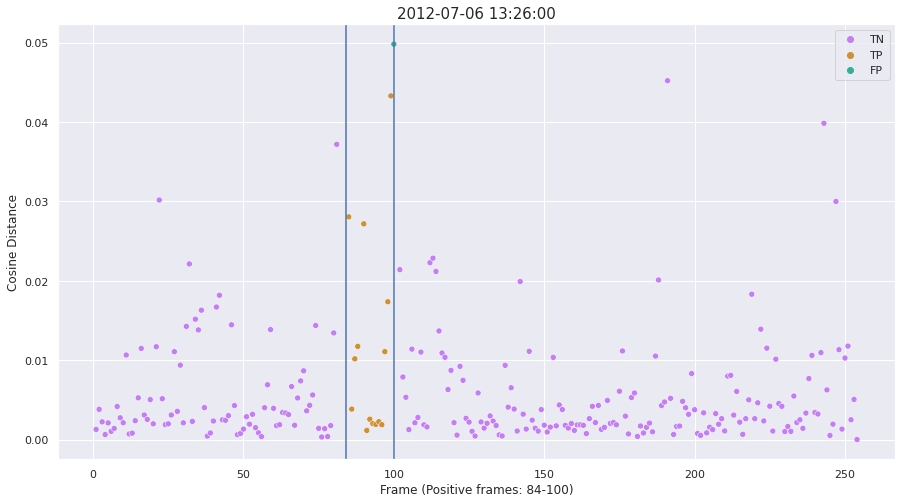

In [88]:
cnt = 0
maxcount = 20
gr = df[emb_cols+['date','frame','svc_poly_preds','label','Year']].sort_values(by='frame').groupby('date')
for name in gr.groups:
    if name != '2012-07-06 13:26:00':
        continue
    group = gr.get_group(name)
    cd = get_cosine_distances(group[emb_cols]) + [0]
    group['cos'] = cd

    fig = plt.figure()
    pos_f = group[group['label'] > 0]['frame'].tolist()
    g2 = group[group['cos']<0.05]#[(group['frame']>70) & (group['frame']<140)]
    colors = g2[['svc_poly_preds','label']].apply(lambda df: 'TP' if (df['svc_poly_preds'] == 1) and (df['label']==1) else 'FP' if df['svc_poly_preds']==1 and df['label']==0 else 'FN' if df['svc_poly_preds']== 0 and df['label']==1 else 'TN', axis=1)
    # print(f"{pos_f[0]-1}: {cd[pos_f[0]-1]}, {pos_f[0]}: {cd[pos_f[0]]}, {pos_f[0]+1}: {cd[pos_f[0]+1]}, {pos_f[-1]-1}: {cd[pos_f[-1]-1]}, {pos_f[-1]}: {cd[pos_f[-1]]}, {pos_f[-1]+1}, {cd[pos_f[-1]+1]}")
    color_cnt = len(colors.unique())
    sns.scatterplot(data=g2, x="frame", y="cos", hue=colors, palette=sns.husl_palette(color_cnt, h=.8))


    plt.title(str(name), fontsize=15)
    plt.xlabel(f'Frame (Positive frames: {pos_f[0]}-{pos_f[-1]})')
    plt.ylabel('Cosine Distance')   
    # plt.gca().axhline(y=0)
    plt.gca().axvline(x=pos_f[0])
    plt.gca().axvline(x=pos_f[-1])

    plt.legend()
    # plt.savefig(f'./figures/07_07_high_prec_test/sine_distance_sample_mean/cosine_distance_sample_mean_07_07_test_{str(name)}')
    # plt.close()
    plt.show()
    cnt +=1
    if cnt == maxcount:
        break

In [ ]:
# df[emb_cols].std(axis=1)

In [ ]:
cnt = 0
df['means'] = df[emb_cols].mean(axis=1)
general_mean = df['means'].mean()
df['std'] = df[emb_cols].std(axis=1)
maxcount = 20
gr = df[emb_cols+['date','frame','svc_poly_preds','label','Year','means','std']].sort_values(by='frame').groupby('date')
for name in gr.groups:
    group = gr.get_group(name)
    # if (not group['svc_poly_preds'].any() or (len(group[group['Year'] < '2011'])>0)):
        # continue

    fig = plt.figure()
    pos_f = group[group['label'] > 0]['frame'].tolist()
    g2 = group#[(group['frame']>70) & (group['frame']<140)]
    colors = g2[['svc_poly_preds','label']].apply(lambda df: 'TP' if (df['svc_poly_preds'] == 1) and (df['label']==1) else 'FP' if df['svc_poly_preds']==1 and df['label']==0 else 'FN' if df['svc_poly_preds']== 0 and df['label']==1 else 'TN', axis=1)
    color_cnt = len(colors.unique())
    sns.scatterplot(data=g2, x="frame", y="std", hue=colors, palette=sns.husl_palette(color_cnt, h=0.8))


    plt.title(str(name), fontsize=15)
    plt.xlabel(f'Frame (Positive frames: {pos_f[0]}-{pos_f[-1]})')
    plt.ylabel('Sample Standard Deviation')   
    plt.gca().axvline(x=pos_f[0])
    plt.gca().axvline(x=pos_f[-1])

    plt.legend()
    # plt.savefig(f'./figures/07_07_high_prec_test/sample_standard_deviation/sample_standard_deviation_07_07_test_{str(name)}')
    # plt.close()


    cnt +=1
    if cnt == maxcount:
        break

In [ ]:
cnt = 0
df['means'] = df[emb_cols].mean(axis=1)
general_mean = df['means'].mean()
df['dif_from_mean'] = general_mean - df['means']
maxcount = 20
gr = df[emb_cols+['date','frame','svc_poly_preds','label','Year','means','dif_from_mean']].sort_values(by='frame').groupby('date')
for name in gr.groups:
    group = gr.get_group(name)
    # if (not group['svc_poly_preds'].any() or (len(group[group['Year'] < '2011'])>0)):
        # continue
    # cd = get_cosine_distances(group[emb_cols]) + [0]
    # group['cos'] = cd

    fig = plt.figure()
    pos_f = group[group['label'] > 0]['frame'].tolist()
    g2 = group#[(group['frame']>70) & (group['frame']<140)]
    colors = g2[['svc_poly_preds','label']].apply(lambda df: 'TP' if (df['svc_poly_preds'] == 1) and (df['label']==1) else 'FP' if df['svc_poly_preds']==1 and df['label']==0 else 'FN' if df['svc_poly_preds']== 0 and df['label']==1 else 'TN', axis=1)
    # print(f"{pos_f[0]-1}: {cd[pos_f[0]-1]}, {pos_f[0]}: {cd[pos_f[0]]}, {pos_f[0]+1}: {cd[pos_f[0]+1]}, {pos_f[-1]-1}: {cd[pos_f[-1]-1]}, {pos_f[-1]}: {cd[pos_f[-1]]}, {pos_f[-1]+1}, {cd[pos_f[-1]+1]}")

    color_cnt = len(colors.unique())
    sns.scatterplot(data=g2, x="frame", y="dif_from_mean", hue=colors, palette=sns.husl_palette(color_cnt, h=.8))

    plt.title(str(name), fontsize=15)
    plt.xlabel(f'Frame (Positive frames: {pos_f[0]}-{pos_f[-1]})')
    plt.ylabel('Test Set Mean - Sample Mean')   
    plt.gca().axhline(y=0)
    plt.gca().axvline(x=pos_f[0])
    plt.gca().axvline(x=pos_f[-1])

    plt.legend()
    plt.savefig(f'./figures/07_07_high_prec_test/mean_difference/mean_dif_07_07_test_{str(name)}')
    plt.close()

    cnt +=1
    if cnt == maxcount:
        break

In [ ]:
cnt = 0
df['medians'] = df[emb_cols].median(axis=1)
df['means'] = df[emb_cols].mean(axis=1)
maxcount = 20
gr = df[emb_cols+['date','frame','svc_poly_preds','label','Year','means','medians']].sort_values(by='frame').groupby('date')
for name in gr.groups:
    group = gr.get_group(name)
    # if (not group['svc_poly_preds'].any() or (len(group[group['Year'] < '2011'])>0)):
        # continue

    fig = plt.figure()
    pos_f = group[group['label'] > 0]['frame'].tolist()
    g2 = group#[(group['frame']>70) & (group['frame']<140)]
    colors = g2[['svc_poly_preds','label']].apply(lambda df: 'TP' if (df['svc_poly_preds'] == 1) and (df['label']==1) else 'FP' if df['svc_poly_preds']==1 and df['label']==0 else 'FN' if df['svc_poly_preds']== 0 and df['label']==1 else 'TN', axis=1)
    color_cnt = len(colors.unique())

    sns.scatterplot(data=g2, x='frame', y='medians', hue=colors, palette=sns.husl_palette(color_cnt, h=.8))

    plt.title(str(name), fontsize=15)
    plt.xlabel(f'Frame (Positive frames: {pos_f[0]}-{pos_f[-1]})')
    plt.ylabel('means')   
    plt.gca().axhline(y=0)
    plt.gca().axvline(x=pos_f[0])
    plt.gca().axvline(x=pos_f[-1])

    plt.legend()
    plt.savefig(f'./figures/07_07_high_prec_test/medians/medians_07_07_test_{str(name)}')
    plt.close()

    cnt +=1
    if cnt == maxcount:
        break


In [ ]:
cnt = 0
df['means'] = df[emb_cols].mean(axis=1)
maxcount = 20
gr = df[emb_cols+['date','frame','svc_poly_preds','label','Year','means']].sort_values(by='frame').groupby('date')
for name in gr.groups:
    group = gr.get_group(name)
    # if (not group['svc_poly_preds'].any() or (len(group[group['Year'] < '2011'])>0)):
        # continue
    cd = get_cosine_distances(group[emb_cols]) + [0]
    group['cos'] = cd

    fig = plt.figure()
    pos_f = group[group['label'] > 0]['frame'].tolist()
    g2 = group#[(group['frame']>70) & (group['frame']<140)]
    colors = g2[['svc_poly_preds','label']].apply(lambda df: 'TP' if (df['svc_poly_preds'] == 1) and (df['label']==1) else 'FP' if df['svc_poly_preds']==1 and df['label']==0 else 'FN' if df['svc_poly_preds']== 0 and df['label']==1 else 'TN', axis=1)
    print(f"{pos_f[0]-1}: {cd[pos_f[0]-1]}, {pos_f[0]}: {cd[pos_f[0]]}, {pos_f[0]+1}: {cd[pos_f[0]+1]}, {pos_f[-1]-1}: {cd[pos_f[-1]-1]}, {pos_f[-1]}: {cd[pos_f[-1]]}, {pos_f[-1]+1}, {cd[pos_f[-1]+1]}")
    # g2.plot(kind='bar',x="frame", y="cos", label="label", cmap='Set2', colorbar=True)#, colorbar=True, color=colors)
    color_cnt = len(colors.unique()) 
    sns.scatterplot(data=g2, x='frame', y='cos', hue=colors, palette=sns.husl_palette(color_cnt, h=.8))

    # plt.plot(np.where(group["label"]==1, group['means'], None), color="red", label="1")
    # plt.plot(np.where(group["label"]==0, group['means'], None), color="blue", label="0")

    plt.title(str(name), fontsize=15)
    plt.xlabel(f'Frame (Positive frames: {pos_f[0]}-{pos_f[-1]})')
    plt.ylabel('Cosine Distances')   
    plt.gca().axhline(y=0)
    plt.gca().axvline(x=pos_f[0])
    plt.gca().axvline(x=pos_f[-1])

    plt.legend()
    # plt.savefig(f'./figures/shuffled_run/cosine_distances/cosine_distances_shuffled_run_test_{str(name)}')
    # plt.close()

    cnt +=1
    if cnt == maxcount:
        break

In [67]:
df = df_unc
cnt = 0
df['means'] = df[emb_cols].mean(axis=1)
maxcount = 20
gr = df[emb_cols+['date','frame','svc_poly_preds','label','Year','means']].sort_values(by='frame').groupby('date')
for name in gr.groups:
    group = gr.get_group(name)
    # if (not group['svc_poly_preds'].any() or (len(group[group['Year'] < '2011'])>0)):
        # continue
    cd = get_cosine_distances(group[emb_cols]) + [0]
    group['cos'] = cd

    fig = plt.figure()
    pos_f = group[group['label'] > 0]['frame'].tolist()
    g2 = group#[(group['frame']>70) & (group['frame']<140)]
    colors = g2[['svc_poly_preds','label']].apply(lambda df: 'TP' if (df['svc_poly_preds'] == 1) and (df['label']==1) else 'FP' if df['svc_poly_preds']==1 and df['label']==0 else 'FN' if df['svc_poly_preds']== 0 and df['label']==1 else 'TN', axis=1)
    print(f"{pos_f[0]-1}: {cd[pos_f[0]-1]}, {pos_f[0]}: {cd[pos_f[0]]}, {pos_f[0]+1}: {cd[pos_f[0]+1]}, {pos_f[-1]-1}: {cd[pos_f[-1]-1]}, {pos_f[-1]}: {cd[pos_f[-1]]}, {pos_f[-1]+1}, {cd[pos_f[-1]+1]}")
    # g2.plot(kind='bar',x="frame", y="cos", label="label", cmap='Set2', colorbar=True)#, colorbar=True, color=colors)
    color_cnt = len(colors.unique()) 
    sns.scatterplot(data=g2, x='frame', y='cos', hue='svc_poly_preds', palette=sns.husl_palette(2, h=.8))

    # plt.plot(np.where(group["label"]==1, group['means'], None), color="red", label="1")
    # plt.plot(np.where(group["label"]==0, group['means'], None), color="blue", label="0")

    plt.title(str(name), fontsize=15)
    plt.xlabel(f'Frame (Positive frames: {pos_f[0]}-{pos_f[-1]})')
    plt.ylabel('Cosine Distances')   
    plt.gca().axhline(y=0)
    # plt.gca().axvline(x=pos_f[0])
    # plt.gca().axvline(x=pos_f[-1])

    plt.legend()
    plt.savefig(f'./figures/shuffled_run/cosine_distances/cosine_distances_shuffled_run_uncertain_{str(name)}')
    plt.close()

    cnt +=1
    if cnt == maxcount:
        break

/tmp/ipykernel_19120/2440230625.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['cos'] = cd
/tmp/ipykernel_19120/2440230625.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['cos'] = cd


81: 0.011992077224900366, 82: 0.0036943909544242537, 83: 0.02599469811570676, 95: 0.004171152480487383, 96: 0.005303560735860913, 97, 0.0011745920093466644
101: 0.0010183640030653196, 102: 0.0006494503761037551, 103: 0.0011979421024786996, 116: 0.002206931580930327, 117: 0.006546458966892654, 118, 0.011611664501124608


/tmp/ipykernel_19120/2440230625.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['cos'] = cd
/tmp/ipykernel_19120/2440230625.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['cos'] = cd


109: 0.0011534374644044387, 110: 0.0022901435241412527, 111: 0.004455319307403949, 123: 0.006347843973837142, 124: 0.0007561172622724266, 125, 0.006092154469790723
91: 0.00779614594817768, 92: 0.0011690798344770048, 93: 0.0039848446645173174, 107: 0.0034582095558717274, 108: 0.0023631972367941234, 109, 0.0006694128927466902


In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

cnt = 0
maxcount = 20
gr = df[emb_cols+['date','frame','svc_poly_preds','label','Year']].sort_values(by='frame').groupby('date')
for name in gr.groups:
    group = gr.get_group(name)

    fig = plt.figure()
    pos_f = group[group['label'] > 0]['frame'].tolist()
    g2 = group
    sim = cosine_similarity(g2[emb_cols])

    colors = g2[['svc_poly_preds','label']].apply(lambda df: 'TP' if (df['svc_poly_preds'] == 1) and (df['label']==1) else 'FP' if df['svc_poly_preds']==1 and df['label']==0 else 'FN' if df['svc_poly_preds']== 0 and df['label']==1 else 'TN', axis=1)
    color_cnt = len(colors.unique()) 

    sns.heatmap(sim)

    plt.title(str(name), fontsize=15)
    plt.xlabel(f'Frame (Positive frames: {pos_f[0]}-{pos_f[-1]})')
    plt.ylabel('Cosine Similarity')   
    plt.gca().axhline(y=0)
    plt.gca().axvline(x=pos_f[0])
    plt.gca().axvline(x=pos_f[-1])

    plt.legend()
    plt.savefig(f'./figures/07_07_high_prec_test/cosine_similarities/cosine_similarity_07_07_test_{str(name)}')
    plt.close()

    cnt +=1
    if cnt == maxcount:
        break

In [ ]:
cnt = 0
maxcount = 20
gr = df[emb_cols+['date','frame','svc_poly_preds','label','Year']].sort_values(by='frame').groupby('date')
for name in gr.groups:
    group = gr.get_group(name)

    fig = plt.figure()
    pos_f = group[group['label'] > 0]['frame'].tolist()
    g2 = group
    
    dist = get_euclidean_distances(g2[emb_cols]) + [0]
    g2['eucl'] = dist
    
    colors = g2[['svc_poly_preds','label']].apply(lambda df: 'TP' if (df['svc_poly_preds'] == 1) and (df['label']==1) else 'FP' if df['svc_poly_preds']==1 and df['label']==0 else 'FN' if df['svc_poly_preds']== 0 and df['label']==1 else 'TN', axis=1)
    color_cnt = len(colors.unique()) 
    sns.scatterplot(data=g2, x='frame', y='eucl', hue=colors, palette=sns.husl_palette(color_cnt, h=.8))

    plt.title(str(name), fontsize=15)
    plt.xlabel(f'Frame (Positive frames: {pos_f[0]}-{pos_f[-1]})')
    plt.ylabel('Euclidean Distance')   
    plt.gca().axhline(y=0)
    plt.gca().axvline(x=pos_f[0])
    plt.gca().axvline(x=pos_f[-1])

    plt.legend()
    plt.savefig(f'./figures/07_07_high_prec_test/euclidean_distances/euclidean-distance_07_07_test_{str(name)}')
    plt.close()

    cnt +=1
    if cnt == maxcount:
        break

In [ ]:
df[(df['date']=='2001-09-24 09:35:00') & (df['label']==1)][['date','frame','svc_poly_preds','label']].sort_values(by='frame').groupby('date').agg(list)

In [ ]:
df[(df['svc_poly_preds']==1) & (df['label']==1)][['date','frame','svc_poly_preds','label']].sort_values(by='frame').groupby('date').agg(list)

DIN ADNOTARILE FOLOSITE LA LABELING - DE PE DRIVE:

2012 03 05 19 27 - 89-109 e quake - detecteaza capetele

2012 03 07 07 52 - 82-94 e quake - detecteaza capetele

2012 07 04 09 47 - 112-130 - detecteaza capetele 

2012 07 06 13 26 - 84-100 - detecteaza capetele

2013-11-08 04:20 - 85-104 - detecteaza capetele

2015 03 11 16:11 - 90-105 - detecteaza capetele

2015 09 28 14 53 - 85-104 - detecteaza capetele

In [ ]:
# reducer=umap.UMAP(n_neighbors=100, min_dist=0.5)
# scaler=StandardScaler()
# import matplotlib.pyplot as plt

# for g in grs.groups:
#     df1 = grs.get_group(g)
#     # print(g)
#     scaled = scaler.fit_transform(df1[emb_cols])
#     embedding_train = reducer.fit(scaled)
#     # umap.plot.output_file(f"./umaps/umaps_07_07_train_set_{'_'.join(g)}.html")
#     ax = umap.plot.points(embedding_train, labels=df1['label'], theme='fire')
#     plt.savefig(f"./umaps/umaps_27_07_val_set_{'_'.join(g)}.png")
#     # umap.plot.show(p)
#     # print(embedding.shape)
#     # hover_data = pd.DataFrame({'index':np.arange(len(df1)),#'transform':np.array(df1['transform']),
#                         # 'name':np.array(df1['name']),
#                         # 'label': df1['label'],'dim':np.array([10 if x == 0 else 20 for x in df1['label']])})
#     plt.close()

# # p = umap.plot.interactive(embedding_train, values=np.array(df1['frame']), hover_data=hover_data, theme='viridis', point_size='dim')



In [49]:
reducer=umap.UMAP(n_neighbors=15, min_dist=0.5)
scaler=StandardScaler()
import matplotlib.pyplot as plt

# f1 = grs.get_group(grs.groups[0])
df1 = df_train.copy()
 # print(g)
scaled = scaler.fit_transform(df1[emb_cols])
embedding_train = reducer.fit_transform(scaled)


scaled_test = scaler.transform(df[emb_cols])
embs = reducer.transform(scaled_test)
# umap.plot.output_file(f"./umaps/umaps_27_07_test_set_all.html") 
# hover_data = pd.DataFrame({'index':np.arange(len(df1)),#'transform':np.array(df1['transform']),
#                         'name':np.array(df1['name']),
#                         'prediction': np.array(df1['logistic_regression_preds']),
#                         'label': df1['label'],'dim':np.array([4 if x == 0 else 10 for x in df1['label']])})
# p = umap.plot.interactive(embedding_train, values=np.array(df1['frame']), hover_data=hover_data, theme='viridis', point_size='dim')
# umap.plot.show(p)

In [50]:
scaled_unc = scaler.transform(df_unc[emb_cols])
embs_unc = reducer.transform(scaled_unc)

In [51]:
df_unc['umap1'] = embs_unc[:,0]
df_unc['umap2'] = embs_unc[:,1]

In [52]:
df['umap1'] = embs[:,0]
df['umap2'] = embs[:,1]

In [53]:
def update_color(df):
    df.loc[(df['label']==1) & (df['svc_poly_preds']==1), 'category'] = 'TP' # TP|
    df.loc[(df['label']==1) & (df['svc_poly_preds']==0), 'category'] = 'FN' # FN
    df.loc[(df['label']==0) & (df['svc_poly_preds']==1), 'category'] = 'FP' # FP
    df.loc[(df['label']==0) & (df['svc_poly_preds']==0), 'category'] = 'TN' # TN
    return df


In [54]:
df = update_color(df)

In [55]:
df_unc = update_color(df_unc)

In [56]:
len(groups)

11

pentru 7 din 11 cutremure detecteaza pozitive, 

In [ ]:
df[((df['svc_poly_preds']==1) & (df['label']==1)) | (df['label']==1)][['date', 'svc_poly_preds', 'label']].groupby('date').agg(sum)

In [ ]:
f

In [ ]:
df = df_u

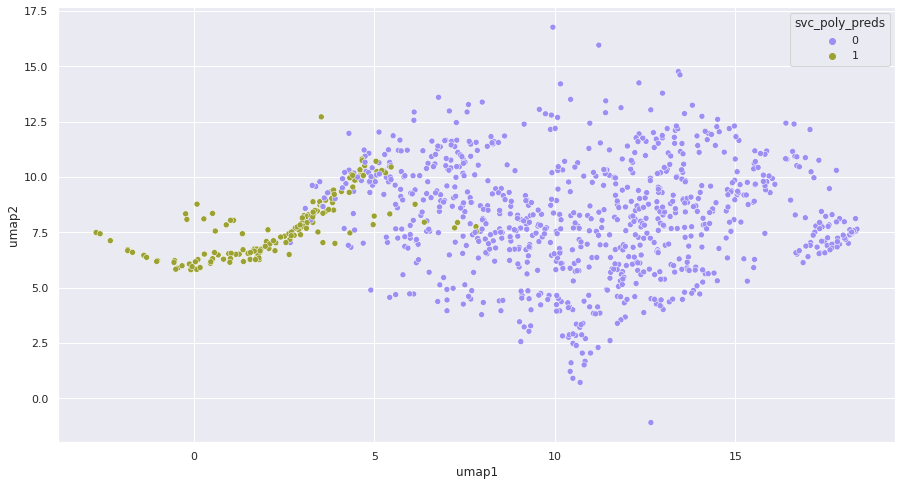

In [76]:
import seaborn as sns
sns.set(rc = {'figure.figsize':(15,8)})
# sns.color_palette("rocket")

grs = df.groupby(['Year','month','day','Hour','Minute'])
groups = [grs.get_group(g) for g in grs.groups]

df1 = groups

plot = sns.scatterplot(data=df_unc, x="umap1", y="umap2", hue='svc_poly_preds', palette=sns.husl_palette(2, h=.75))

fig = plot.get_figure()
fig.savefig("./figures/shuffled_run/shuffled_run_predictions_umap.png") 

In [81]:
df_unc[(df_unc['svc_poly_preds']==1)&(df_unc['date']=='2011-09-25 08:46:00')][['date','frame']].sort_values(by=['date','frame'])

,date,frame
240,2011-09-25 08:46:00,87
242,2011-09-25 08:46:00,89


In [ ]:
df[(df['svc_poly_preds']==1) & (df['label']==0)][['Year','Minute','frame']]

In [ ]:
from sklearn.metrics import classification_report,confusion_matrix

print (confusion_matrix(df['label'],df['svc_poly_preds']))
print (classification_report(df['label'],df['svc_poly_preds']))

Analysis